Name: Zihan Qin

Github: zihan-qin

USCID: 8130 9206 33


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,roc_curve,roc_auc_score,RocCurveDisplay,confusion_matrix,accuracy_score,auc
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import os
import random
from sklearn.utils import resample
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.feature_selection import RFECV,RFE
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from regressors import stats
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler,scale
from liblinear.liblinearutil import *
import scipy
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


1.(a)-(c)ii

In [2]:
class dataset:
    def __init__(self,series_break):
        self.series_break = series_break
        self.c_name = []
        self.s_name = []
        for j in range(1,6*series_break+1):
            for i in ['min','max','mean','median','std','first_quartile','third_quartile']:
                self.c_name.append(i+"_"+str(j))
            for k in ['max','median','third_quartile']:
                self.s_name.append(k+'_'+str(j))
        self.dataset = pd.DataFrame(columns=self.c_name)
        self.featureset = pd.DataFrame(columns=self.s_name)
    def feature_extraction(self,path):
        tag = path.split('/')[-2]
        data = pd.read_csv(path,skiprows=4,error_bad_lines=False)
        data = data.drop(['# Columns: time'],axis=1)
        interval = len(data)//self.series_break
        for i in range(self.series_break-1):
         
            tmp_data = data.loc[i*interval:(i+1)*interval-1,:]
           
            tmp_agg = tmp_data.aggregate(['min','max','mean','median','std'])
            q1 = {}
            q3 = {}
            for j in tmp_agg:
                q1[j] = np.percentile(tmp_data[j],25)
                q3[j] = np.percentile(tmp_data[j],75)
            tmp_agg = tmp_agg.append(q1,ignore_index=True)
            tmp_agg = tmp_agg.append(q3,ignore_index=True)
            if i == 0:
                tmp = tmp_agg
            else:
                tmp = pd.concat([tmp,tmp_agg],axis=1)
        tmp_data = data.loc[(self.series_break-1)*interval:,:]
        tmp_agg = tmp_data.aggregate(['min','max','mean','median','std'])
        q1 = {}
        q3 = {}
        for i in tmp_agg:
            q1[i] = np.percentile(tmp_data[i],25)
            q3[i] = np.percentile(tmp_data[i],75)
        tmp_agg = tmp_agg.append(q1,ignore_index=True)
        tmp_agg = tmp_agg.append(q3,ignore_index=True)
        if self.series_break == 1:
            tmp = tmp_agg
        else:
            tmp = pd.concat([tmp,tmp_agg],axis=1)
        
        tmp.index = ['min','max','mean','median','std','first_quartile','third_quartile']
        tmp = pd.DataFrame(np.array(tmp.T).ravel().reshape(1,-1),columns=self.c_name)
        tmp['y'] = tag
        self.dataset = self.dataset.append(tmp)
        self.dataset.index = range(len(self.dataset))
    def selected_feature(self,path):
        tag = path.split('/')[-2]
        data = pd.read_csv(path,skiprows=4,error_bad_lines=False)
        data = data.drop(['# Columns: time'],axis=1)
    
        interval = len(data)//self.series_break
        for i in range(self.series_break-1):
            
            tmp_data = data.loc[i*interval:(i+1)*interval-1,:]
            
            tmp_agg = tmp_data.aggregate(['max','median'])
            q3 = {}
            for j in tmp_agg:
                q3[j] = np.percentile(tmp_data[j],75)
            tmp_agg = tmp_agg.append(q3,ignore_index=True)
            if i == 0:
                tmp = tmp_agg
            else:
                tmp = pd.concat([tmp,tmp_agg],axis=1)
        tmp_data = data.loc[(self.series_break-1)*interval:,:]
       
        tmp_agg = tmp_data.aggregate(['max','median'])
        q3 = {}
        for i in tmp_agg:
            q3[i] = np.percentile(tmp_data[i],75)
        tmp_agg = tmp_agg.append(q3,ignore_index=True)
        if self.series_break == 1:
            tmp = tmp_agg
        else:
            tmp = pd.concat([tmp,tmp_agg],axis=1)
        
        tmp.index = ['max','median','third_quartile']
        tmp = pd.DataFrame(np.array(tmp.T).ravel().reshape(1,-1),columns=self.s_name)
        tmp['y'] = tag
        self.featureset = self.featureset.append(tmp)
        self.featureset.index = range(len(self.featureset))
    def binary_class(self):
        bc = []
        for i in self.featureset['y']:
            if i == 'bending1' or i == 'bending2':
                bc.append(1)
            else:
                bc.append(0)
        self.featureset['y'] = bc

In [3]:
trainset = dataset(1)
testset = dataset(1)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.feature_extraction(dirpath+'/'+csv)
            else:
                trainset.feature_extraction(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.feature_extraction(dirpath+'/'+csv)
            else:
                trainset.feature_extraction(dirpath+'/'+csv)
trainset = trainset.dataset
testset = testset.dataset

In [4]:
trainset

,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,y
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.8300,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700,bending1
2,33.00,47.75,42.179812,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.0000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.9400,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600,cycling
65,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000,cycling
66,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175,cycling
67,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300,cycling


In [5]:
total_data = trainset.append(testset)
total_data.index = range(len(total_data))
total_data

,min_1,max_1,mean_1,median_1,std_1,first_quartile_1,third_quartile_1,min_2,max_2,mean_2,...,first_quartile_5,third_quartile_5,min_6,max_6,mean_6,median_6,std_6,first_quartile_6,third_quartile_6,y
0,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.49,0.487826,0.0000,0.83,bending1
1,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.50,0.622534,0.4300,0.87,bending1
2,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.50,0.524317,0.0000,1.00,bending1
3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.43,0.389164,0.0000,0.50,bending1
4,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.43,0.513506,0.0000,0.94,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,24.75,48.33,44.182937,48.000,7.495615,48.00,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.50,0.675781,0.3225,0.94,lying
84,48.00,48.25,48.004167,48.000,0.032038,48.00,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.50,0.388372,0.4600,0.83,lying
85,24.25,45.00,37.177042,36.250,3.581301,34.50,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.50,1.852600,1.5000,3.90,cycling
86,28.75,44.75,37.561187,36.875,3.226507,35.25,40.2500,0.0,9.91,2.080687,...,18.0000,21.5000,0.0,9.62,2.765896,2.45,1.769203,1.4100,3.77,cycling


1(c)iii

In [6]:
data_features = total_data.drop('y',axis=1)

In [7]:
bs_std = []
for i in data_features:
    bs_res = bs.bootstrap(np.array(data_features[i]),stat_func=bs_stats.std,alpha=0.10)
    bs_std.append([i,bs_res.value,bs_res.lower_bound,bs_res.upper_bound])
    
bs_std = pd.DataFrame(bs_std,columns=['feature','std_estimation','lower_bound','upper_bound'])

In [8]:
bs_std

,feature,std_estimation,lower_bound,upper_bound
0,min_1,9.515445,8.331667,10.807398
1,max_1,4.369322,3.462541,5.419298
2,mean_1,5.305314,4.753710,5.928859
3,median_1,5.409056,4.854675,6.049155
4,std_1,1.762056,1.588468,1.961293
5,first_quartile_1,6.118526,5.642056,6.695461
6,third_quartile_1,5.109643,4.421801,5.919721
7,min_2,0.000000,0.000000,0.000000
8,max_2,5.033882,4.687087,5.471028
9,mean_2,1.565194,1.435174,1.742912


1(c)iv

In [9]:
bs_std.sort_values(by='std_estimation',ascending=False)

,feature,std_estimation,lower_bound,upper_bound
0,min_1,9.515445,8.331667,10.807398
5,first_quartile_1,6.118526,5.642056,6.695461
28,min_5,6.089107,4.681730,7.781036
33,first_quartile_5,6.061727,4.946086,7.327716
31,median_5,5.780655,4.694614,7.080301
29,max_5,5.708524,4.888145,6.671169
30,mean_5,5.643253,4.583329,6.853923
34,third_quartile_5,5.500200,4.485961,6.667900
3,median_1,5.409056,4.854675,6.049155
2,mean_1,5.305314,4.753710,5.928859


In [10]:
feature_std = pd.DataFrame(data_features.aggregate(func='std').sort_values(ascending=False),columns=["std"])

In [11]:
fs_dic = {}
for i in feature_std.index:
    if 'min' in i:
        fs_dic['min_std'] = fs_dic.get('min_std',0) + feature_std.loc[i,'std']
    elif 'max' in i:
        fs_dic['max_std'] = fs_dic.get('max_std',0) + feature_std.loc[i,'std']
    elif 'median' in i:
        fs_dic['median_std'] = fs_dic.get('median_std',0) + feature_std.loc[i,'std']
    elif 'mean' in i:
        fs_dic['mean_std'] = fs_dic.get('mean_std',0) + feature_std.loc[i,'std']
    elif 'first' in i:
        fs_dic['fq_std'] = fs_dic.get('fq_std',0) + feature_std.loc[i,'std']
    elif 'third' in i:
        fs_dic['tq_std'] = fs_dic.get('tq_std',0) + feature_std.loc[i,'std']
    else:
        fs_dic['std_std'] = fs_dic.get('std_std',0) + feature_std.loc[i,'std']
        

In [12]:
print(fs_dic)


{'min_std': 18.696276928288565, 'fq_std': 19.01930250071581, 'median_std': 18.934537043776956, 'max_std': 24.776012517083423, 'mean_std': 18.914780929383582, 'tq_std': 20.043642767599206, 'std_std': 5.603726215181819}


Since the variance can include the information of predicting the difference of dependent variable, According to the features which have the largest variance, I think max, third quartile, median may be the three important features. (I changed the feature selected in HW4 to those more reasonable ones. In hw3, I used to choose min, median, first_quarter.)

**Homework 4**

2(a)i

In [13]:
trainset = dataset(1)
testset = dataset(1)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)

trainset.binary_class()
testset.binary_class()
trainset = trainset.featureset
testset = testset.featureset

In [14]:

train_b = trainset.loc[:,['max_1','max_2','max_6','third_quartile_1','third_quartile_2','third_quartile_6','median_1','median_2','median_6','y']]

Text(0.5, 0.98, 'scatter plot of features')

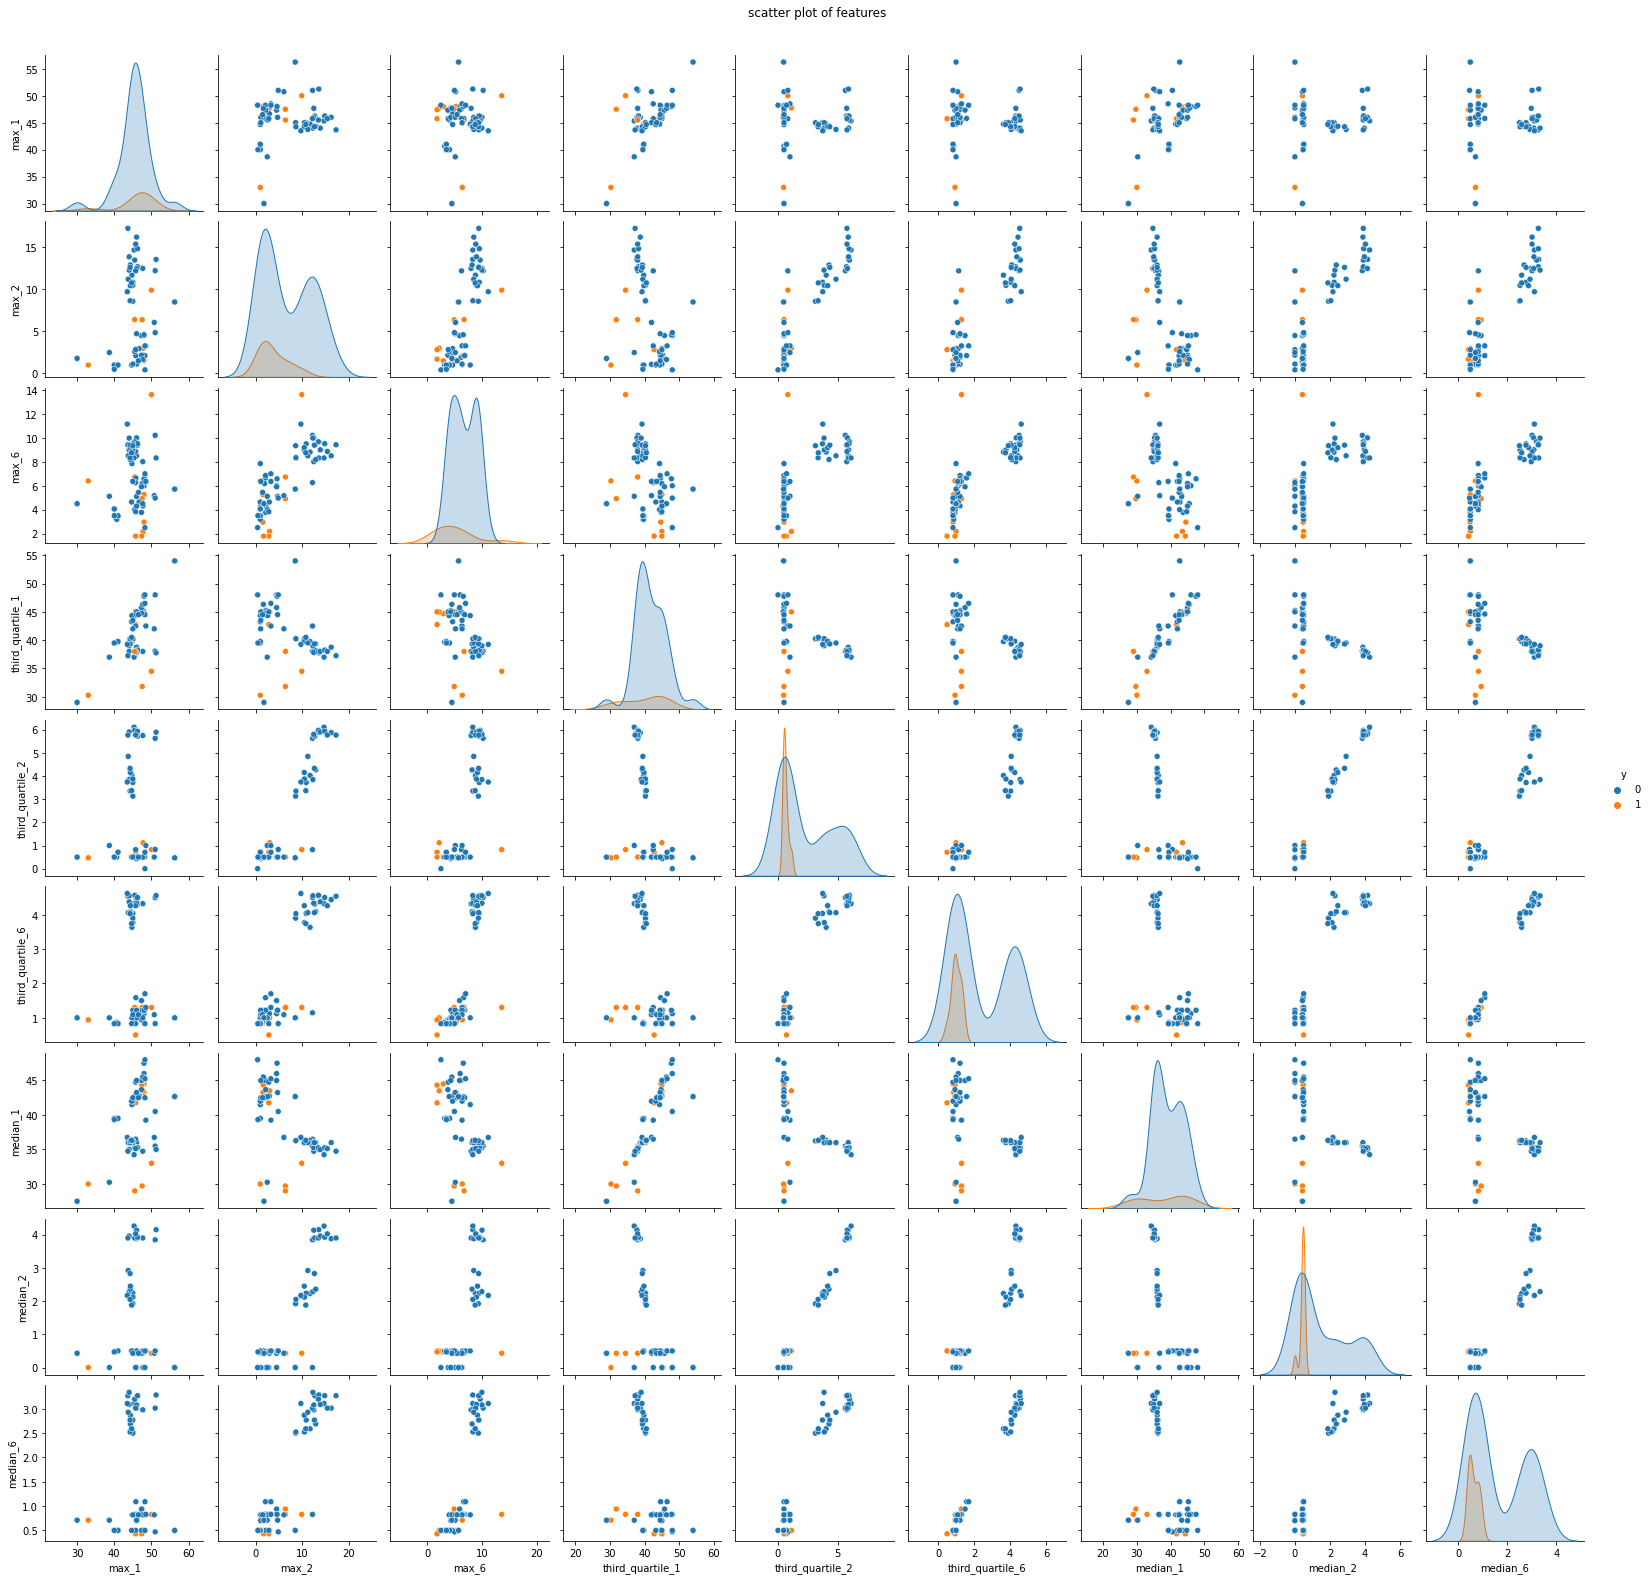

In [15]:
ax = sns.pairplot(train_b,kind='scatter',hue='y')
ax.fig.subplots_adjust(top=0.95)
ax.fig.suptitle("scatter plot of features")

2(a)ii

In [16]:
trainset_2 = dataset(2)
testset_2 = dataset(2)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset_2.selected_feature(dirpath+'/'+csv)
            else:
                trainset_2.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset_2.selected_feature(dirpath+'/'+csv)
            else:
                trainset_2.selected_feature(dirpath+'/'+csv)
                
trainset_2.binary_class()
testset_2.binary_class()
trainset_2 = trainset_2.featureset
testset_2 = testset_2.featureset

Text(0.5, 0.98, 'features scatter plot of trainset_2')

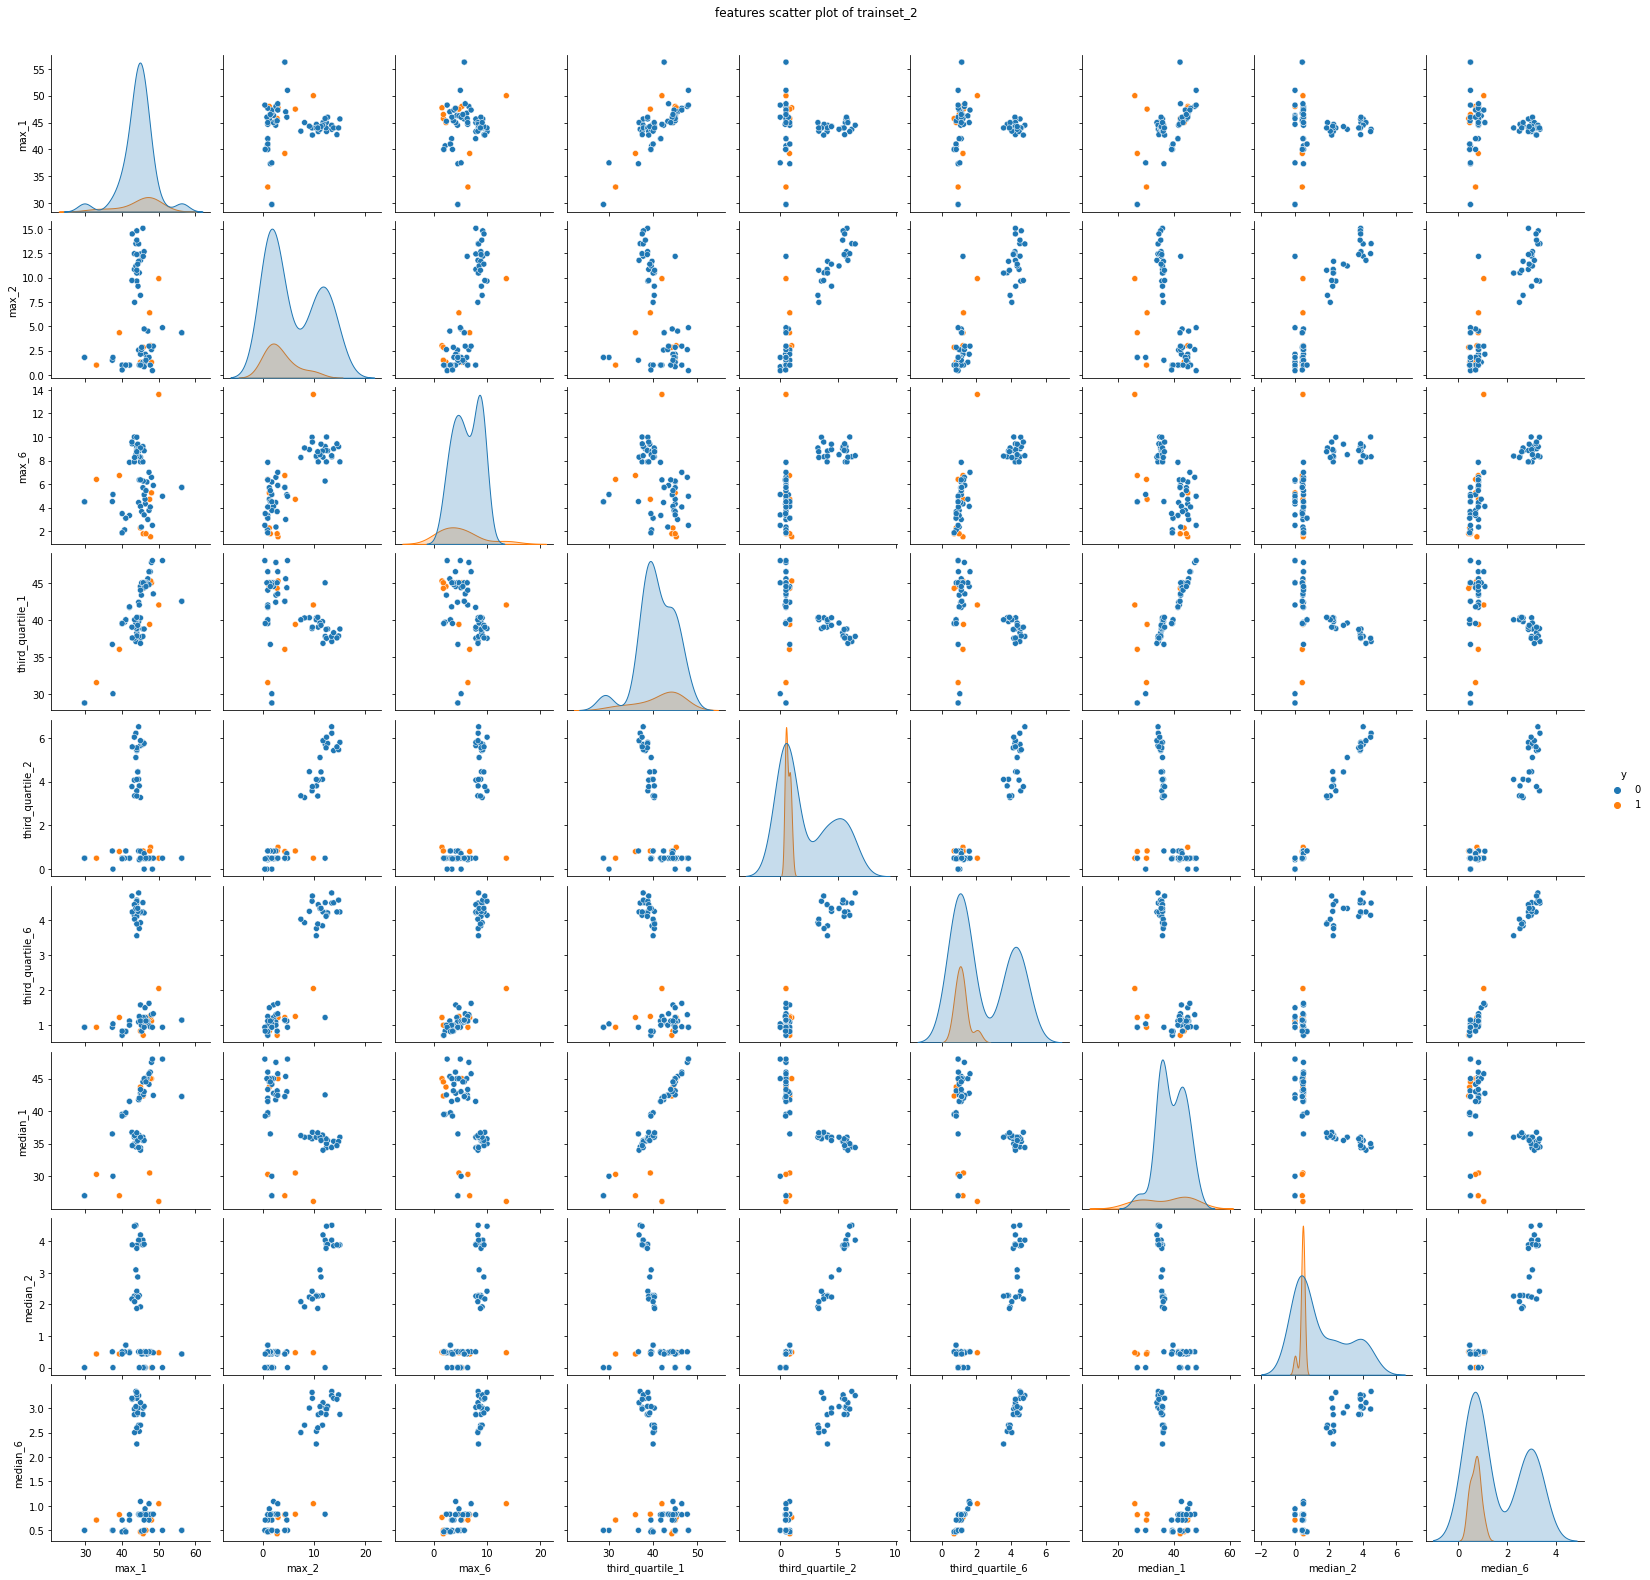

In [17]:
train_b = trainset_2.loc[:,['max_1','max_2','max_6','third_quartile_1','third_quartile_2','third_quartile_6','median_1','median_2','median_6','y']]

ax = sns.pairplot(train_b,kind='scatter',hue='y')
ax.fig.subplots_adjust(top=0.95)
ax.fig.suptitle("features scatter plot of trainset_2")

There is not considerable difference before and after division , thus I think the statistics are not increase or decrease through the time.

2(a)iii

In [18]:
lp = {}
for l in range(1,21):
    trainset = dataset(l)
    testset = dataset(l)
    path = '../data/AReM'
    folders = next(os.walk(path))[1]
    for i in folders:
        dirpath = path+'/'+i
        datacsv = datacsv = os.listdir(dirpath)
        if i == 'bending1' or i == 'bending2':
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
        else:
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
    trainset.binary_class()
    testset.binary_class()
    trainset = trainset.featureset
    testset = testset.featureset
    y = trainset['y']
    x = trainset.drop(['y'],axis=1)
    lr = LogisticRegression()
    fs = RFECV(lr,cv=5,scoring='accuracy')
    fs = fs.fit(x,y)
    lp[(l,len(fs.get_feature_names_out()))]=round(fs.cv_results_['mean_test_score'][fs.n_features_-1],4)

In [19]:
lp

{(1, 1): 0.9571,
 (2, 1): 0.9429,
 (3, 1): 0.9857,
 (4, 1): 0.9714,
 (5, 1): 0.9714,
 (6, 1): 0.9714,
 (7, 5): 0.9429,
 (8, 1): 0.956,
 (9, 12): 0.9571,
 (10, 1): 0.9429,
 (11, 1): 0.9571,
 (12, 1): 0.9571,
 (13, 1): 0.9571,
 (14, 1): 0.9571,
 (15, 5): 0.9429,
 (16, 5): 0.9429,
 (17, 1): 0.9571,
 (18, 1): 0.9571,
 (19, 1): 0.9571,
 (20, 1): 0.9571}

In [20]:
lp_max = max(list(lp.values()))
for i in lp:
    if lp[i] == lp_max:
        print(i)

(3, 1)


The right way to use the cv is to select the (l,p) with the mean score of cv results rather than the prediction score of all train dataset.

Since the model with l = 3, p = 1 have the highest scores above all model, I think this can be the best value.

2(a)iv

In [21]:
trainset = dataset(3)
testset = dataset(3)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
trainset.binary_class()
testset.binary_class()
trainset = trainset.featureset
testset = testset.featureset
y = trainset['y']
x = trainset.drop(['y'],axis=1)
lr = LogisticRegression()
fs = RFECV(lr,cv=5)
fs = fs.fit(x,y)
fs.get_feature_names_out()

array(['third_quartile_5'], dtype=object)

In [22]:
x_select = trainset['third_quartile_5']
x_select = x_select[:,np.newaxis]
lr = LogisticRegression()
lr.fit(x_select,np.array(trainset['y']))
y_pred = lr.predict(x_select.reshape(-1,1))

In [23]:
print('accuracy on train set is:',round(lr.score(x_select.reshape(-1,1),y),2))

accuracy on train set is: 0.97


confusion matrix: 
 [[60  0]
 [ 2  7]]


Text(0.5, 1.0, 'the ROC curve and AUC of the model')

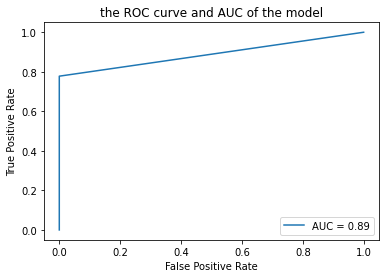

In [24]:
fpr, tpr, threshold = roc_curve(trainset['y'],y_pred)

print('confusion matrix:','\n',confusion_matrix(trainset['y'],y_pred))
auc_score = roc_auc_score(trainset['y'],y_pred)
RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()
plt.title('the ROC curve and AUC of the model')

In [25]:
stats.summary(lr,x_select,y)

Residuals:
 Min  1Q  Median  3Q  Max
-0.0 0.0     0.0 0.0  1.0


Coefficients:
             Estimate  Std. Error   t value  p value
_intercept -18.806969    0.065069 -289.0324      0.0
x1           0.824779    0.001264  652.5807      0.0
---
R-squared:  0.74444,    Adjusted R-squared:  0.74063
F-statistic: 195.17 on 1 features


According to the report, $\beta_0$ should be -18.81, $\beta_1$ should be 0.82. p values are 0 for both third_quartile_5 and intercept.


The accuaray on train data is 0.97. The ROC and AUC can be seen in the plot.

2(a)v

In [26]:
y_test = testset['y']
x_test = testset.drop('y',axis=1).loc[:,'third_quartile_5']
y_pred= lr.predict(np.array(x_test).reshape(-1,1))

In [27]:
print('accuracy of test set:',round(lr.score(np.array(x_test).reshape(-1,1),y_test),2))

accuracy of test set: 0.95


The train set accuracy is 0.97. Test set accuracy is little bit less than train set accuracy since the model is fit on the trainset and the model have already seen the labels of trainset data. But they are very closed, so I think this is normal.

In [28]:
acc_test = accuracy_score(y_test,y_pred)
confusion_matrix(y_test,y_pred)

array([[15,  0],
       [ 1,  3]])

2(a)vi

I think the classes is well seperated, because the p-values of coeffience are almost 0.

2(a)v

From the trainset prediction confusion matrix, I think there is imbalanced class. The recall of other is 1, while the recall of bending is 0.78.

I use Random over sampler to build the new model.

In [29]:
ros = RandomOverSampler(random_state=10)
x_os, y_os = ros.fit_resample(x_select,y)

In [30]:
lr_os = LogisticRegression()
lr_os.fit(np.array(x_os).reshape(-1,1),np.array(y_os))
os_pred = lr_os.predict(np.array(x_os).reshape(-1,1))
print('confusion matrix:','\n',confusion_matrix(y_os,os_pred))

confusion matrix: 
 [[55  5]
 [ 8 52]]


In [31]:
os_pred = os_pred = lr_os.predict(np.array(x_test).reshape(-1,1))

confusion matrix: 
 [[10  5]
 [ 1  3]]


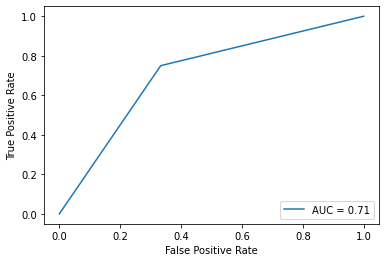

In [32]:
fpr, tpr, threshold = roc_curve(y_test,os_pred)
print('confusion matrix:','\n',confusion_matrix(y_test,os_pred))
auc_score = roc_auc_score(y_test,os_pred)
RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score).plot()

The accuracy of the model is lower and the recall of bending in test set doesn't improve. But the random sample indeed reduce the probability to classify samples to class 0.

I think one of the reason is that the size of test set is too small. I believe that if there is more data, the recall of bending in test set can be better.

2(b)i

In [33]:
ll = {}
for l in range(1,21):
    trainset = dataset(l)
    testset = dataset(l)
    path = '../data/AReM'
    folders = next(os.walk(path))[1]
    for i in folders:
        dirpath = path+'/'+i
        datacsv = datacsv = os.listdir(dirpath)
        if i == 'bending1' or i == 'bending2':
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
        else:
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
    trainset.binary_class()
    testset.binary_class()
    trainset = trainset.featureset
    testset = testset.featureset
    trainset.index = range(len(trainset))
    testset.index = range(len(testset))
    y = trainset['y']
    x = trainset.drop(['y'],axis=1)
    scaler = StandardScaler()
    scale_train = scaler.fit_transform(x)
    clr = LogisticRegressionCV(cv=5,random_state=10,penalty='l1',solver='liblinear')
    clr.fit(scale_train,trainset['y'])
    scores = clr.scores_[1].mean(axis=0)
    lambda1 = round(1/clr.Cs_[scores.argmax()],4)
    ll[(l,lambda1)] = round(scores.max(),4)

In [34]:
ll

{(1, 2.7826): 0.9571,
 (2, 2.7826): 0.9429,
 (3, 2.7826): 0.9429,
 (4, 0.0008): 0.9286,
 (5, 0.3594): 0.9571,
 (6, 0.3594): 0.9429,
 (7, 2.7826): 0.9429,
 (8, 0.3594): 0.9571,
 (9, 0.006): 0.9286,
 (10, 0.3594): 0.9429,
 (11, 2.7826): 0.9429,
 (12, 0.3594): 0.9571,
 (13, 2.7826): 0.9571,
 (14, 0.3594): 0.9571,
 (15, 0.3594): 0.9571,
 (16, 0.3594): 0.9571,
 (17, 0.3594): 0.9571,
 (18, 2.7826): 0.9571,
 (19, 0.3594): 0.9571,
 (20, 2.7826): 0.9571}

In [35]:
print('The best (l,lambda) should be:',list(ll.keys())[np.array(list(ll.values())).argmax()])

The best (l,lambda) should be: (1, 2.7826)


2(b)ii

I will say rfe performs better since its optimal model has higher score than the optimal L1 model. But L1-penalty is easier to implement by the running time.

2(c)i

In [36]:
multi_acc = {}
multi_label = ['bending1','bending2','cycling','lying','sitting','standing','walking']

In [37]:
def multi_roc(classify_model,modelname,traindataset,trainy,testdataset,testy):
    b_label = list(set(trainy)-{'bending1'})
    trainy = label_binarize(trainy, classes=b_label)
    testy = label_binarize(testy, classes=b_label)
    n_classes = trainy.shape[1]
    n_samples = len(traindataset)+len(testdataset)
    n_features = traindataset.shape
    model = OneVsRestClassifier(classify_model)
    model = model.fit(traindataset,trainy)
    y_pred = model.predict_proba(testdataset)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(testy[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(testy.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw=2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='ROC curve (auc = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=lw)

    colors = cycle(['r','orange','gold','g','c','dodgerblue','purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of {0} (auc = {1:0.2f})'
                ''.format(multi_label[i], roc_auc[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of %s model'%modelname)
    plt.legend(loc="lower right")
    plt.show()

In [38]:
ll_m = {}
for l in range(1,21):
    trainset = dataset(l)
    testset = dataset(l)
    path = '../data/AReM'
    folders = next(os.walk(path))[1]
    for i in folders:
        dirpath = path+'/'+i
        datacsv = datacsv = os.listdir(dirpath)
        if i == 'bending1' or i == 'bending2':
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
        else:
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
    
    trainset = trainset.featureset
    testset = testset.featureset
    trainset.index = range(len(trainset))
    testset.index = range(len(testset))
    y = trainset['y']
    x = trainset.drop(['y'],axis=1)
    scaler = StandardScaler()
    scale_train = scaler.fit_transform(x)
    clr = LogisticRegressionCV(cv=5,random_state=10,penalty='l1',solver='saga',multi_class='multinomial')
    clr.fit(scale_train,trainset['y'])
    scores = []
    for key, value in clr.scores_.items():
        scores.append(value.mean(axis=0))
    scores_lambda = np.mean(scores,axis=0)
    lambda1 = round(1/clr.Cs_[scores_lambda.argmax()],4)
    ll_m[(l,lambda1)] = round(scores_lambda.max(),4)

In [39]:
ll_m

{(1, 0.0464): 0.8549,
 (2, 0.3594): 0.8692,
 (3, 0.006): 0.8407,
 (4, 0.006): 0.811,
 (5, 0.0464): 0.7813,
 (6, 0.006): 0.8264,
 (7, 0.3594): 0.8121,
 (8, 0.3594): 0.7681,
 (9, 0.0008): 0.8418,
 (10, 0.0008): 0.7824,
 (11, 0.0464): 0.8264,
 (12, 0.0464): 0.7835,
 (13, 0.3594): 0.7681,
 (14, 0.0008): 0.7824,
 (15, 0.0001): 0.7835,
 (16, 0.0464): 0.7396,
 (17, 0.0001): 0.7824,
 (18, 0.0008): 0.7824,
 (19, 0.0001): 0.7681,
 (20, 0.3594): 0.7538}

In [40]:
print('The best (l,lambda) should be:',list(ll_m.keys())[np.array(list(ll_m.values())).argmax()])

The best (l,lambda) should be: (2, 0.3594)


In [41]:
c_optimal = 1/0.3595

In [42]:
trainset = dataset(2)
testset = dataset(2)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
trainset = trainset.featureset
testset = testset.featureset
y_train = trainset['y']
x_train = trainset.drop(['y'],axis=1)
scaler = StandardScaler()
scale_train = scaler.fit_transform(x_train)
clr = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial',C=c_optimal)
clr = clr.fit(scale_train,trainset['y'])

In [43]:
x_test = testset.drop(['y'],axis=1)
x_test = scaler.transform(x_test)
y_test = testset['y']
clr_pred = clr.predict(x_test)
clr_acc = round(clr.score(x_test,testset['y']),2)
multi_acc['l1-lr'] = clr_acc
print('test set accuracy:',clr_acc)

test set accuracy: 0.95


In [44]:
cm_clr = confusion_matrix(y_test,clr_pred,labels=multi_label)
print('confusion matrix of L1 muli-class classification model:','\n',pd.DataFrame(cm_clr,columns=multi_label,index=multi_label))

confusion matrix of L1 muli-class classification model: 
           bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         1        0      0        1         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      0        0         3        0
walking          0         0        0      0        0         0        3


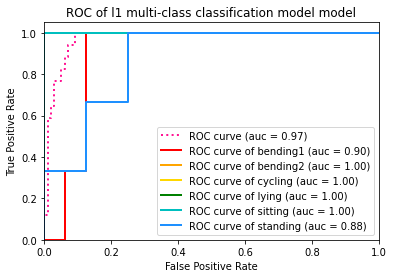

In [45]:
multi_roc(clr,'l1 multi-class classification model',scale_train,y_train,x_test,y_test)

2(c)ii

In [46]:
gnb_l = {}
mnb_l = {}
for l in range(1,21):
    trainset = dataset(l)
    testset = dataset(l)
    path = '../data/AReM'
    folders = next(os.walk(path))[1]
    for i in folders:
        dirpath = path+'/'+i
        datacsv = datacsv = os.listdir(dirpath)
        if i == 'bending1' or i == 'bending2':
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
        else:
            for csv in datacsv:
                if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                    testset.selected_feature(dirpath+'/'+csv)
                else:
                    trainset.selected_feature(dirpath+'/'+csv)
    
    trainset = trainset.featureset
    testset = testset.featureset
    trainset.index = range(len(trainset))
    testset.index = range(len(testset))
    y = trainset['y']
    x = trainset.drop(['y'],axis=1)
    y_test = testset['y']
    x_test = testset.drop(['y'],axis=1)
 #   scaler = StandardScaler()
 #   scale_train = scaler.fit_transform(x)
    
    kfold = StratifiedKFold(shuffle=True,random_state=10)
    
    gnb_tmp = []
    mnb_tmp = []
    
    
    gnb = GaussianNB()
    gnb.fit(x,y)
    gnb_l[l] = round(gnb.score(x_test,y_test),4)
    mnb = MultinomialNB()
    mnb.fit(x,y)
    mnb_l[l] = round(mnb.score(x_test,y_test),4)
    


In [47]:
mnb_l

{1: 1.0,
 2: 0.9474,
 3: 0.9474,
 4: 0.9474,
 5: 0.9474,
 6: 0.9474,
 7: 0.9474,
 8: 0.8947,
 9: 0.8947,
 10: 0.8947,
 11: 0.8947,
 12: 0.8947,
 13: 0.8947,
 14: 0.8421,
 15: 0.8947,
 16: 0.8947,
 17: 0.8947,
 18: 0.8421,
 19: 0.8947,
 20: 0.8421}

In [48]:
print('The best l of multinomial NB should be:',list(mnb_l.keys())[np.array(list(mnb_l.values())).argmax()])

The best l of multinomial NB should be: 1


In [49]:
gnb_l

{1: 1.0,
 2: 0.7895,
 3: 0.8421,
 4: 0.8421,
 5: 0.8421,
 6: 0.7368,
 7: 0.7368,
 8: 0.7895,
 9: 0.6842,
 10: 0.7368,
 11: 0.7368,
 12: 0.7895,
 13: 0.7368,
 14: 0.7895,
 15: 0.7368,
 16: 0.8421,
 17: 0.7895,
 18: 0.7368,
 19: 0.7368,
 20: 0.8421}

In [50]:
print('The best l of gaussian NB should be:',list(gnb_l.keys())[np.array(list(gnb_l.values())).argmax()])

The best l of gaussian NB should be: 1


In [51]:
trainset = dataset(1)
testset = dataset(1)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
trainset = trainset.featureset
testset = testset.featureset
y = trainset['y']
x_train = trainset.drop(['y'],axis=1)
y_test = testset['y']
x_test = testset.drop(['y'],axis=1)
gnb = GaussianNB()
gnb = gnb.fit(x_train,y)
gnb_pred = gnb.predict(x_test)

In [52]:
gnb_acc = round(accuracy_score(y_test,gnb_pred),2)
multi_acc['gnb'] = gnb_acc
print("gnb test set score:", gnb_acc)

gnb test set score: 1.0


In [53]:
cm_gnb = confusion_matrix(y_test,gnb_pred,labels=multi_label)
print('confusion matrix of GNB classification model:','\n',pd.DataFrame(cm_gnb,columns=multi_label,index=multi_label))

confusion matrix of GNB classification model: 
           bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         2        0      0        0         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      0        0         3        0
walking          0         0        0      0        0         0        3


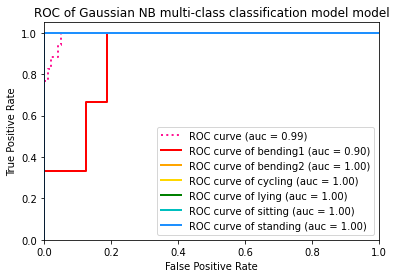

In [54]:
multi_roc(gnb,'Gaussian NB multi-class classification model',x_train,y,x_test,y_test)

In [55]:
trainset = dataset(1)
testset = dataset(1)
path = '../data/AReM'
folders = next(os.walk(path))[1]
for i in folders:
    dirpath = path+'/'+i
    datacsv = datacsv = os.listdir(dirpath)
    if i == 'bending1' or i == 'bending2':
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
    else:
        for csv in datacsv:
            if csv == 'dataset1.csv' or csv == 'dataset2.csv' or csv == 'dataset3.csv':
                testset.selected_feature(dirpath+'/'+csv)
            else:
                trainset.selected_feature(dirpath+'/'+csv)
trainset = trainset.featureset
testset = testset.featureset
y_train = trainset['y']
x_train = trainset.drop(['y'],axis=1)
y_test = testset['y']
x_test= testset.drop(['y'],axis=1)
mnb = MultinomialNB()
mnb = mnb.fit(x_train,y_train)
mnb_pred = mnb.predict(x_test)

In [56]:
mnb_acc = round(accuracy_score(y_test,mnb_pred),2)
multi_acc['mnb'] = mnb_acc
print("mnb test set score:", mnb_acc)

mnb test set score: 1.0


confusion matrix of MNB classification model: 
           bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         2        0      0        0         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      0        0         3        0
walking          0         0        0      0        0         0        3


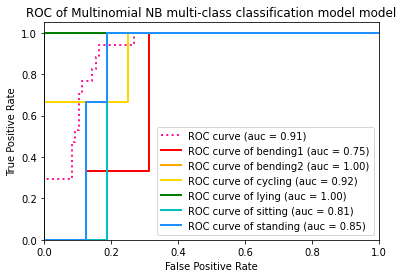

In [57]:
cm_mnb = confusion_matrix(y_test,mnb_pred,labels=multi_label)
print('confusion matrix of MNB classification model:','\n',pd.DataFrame(cm_mnb,columns=multi_label,index=multi_label))
multi_roc(mnb,'Multinomial NB multi-class classification model',x_train,y_train,x_test,y_test)

In [58]:
multi_acc

{'l1-lr': 0.95, 'gnb': 1.0, 'mnb': 1.0}

According to the accuracy, I think naive bayes' classifier is the best model, and according to the ROC curve, I think gaussian naive bayes' model can classify the data better and robuster.

ISLR 4.8.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class- specific mean vector and a class specific covariance matrix. We con- sider the simple case where p = 1; i.e. there is only one feature.
Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal dis- tribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.
Hint: For this problem, you should follow the arguments laid out in Section 4.4.1, but without making the assumption that σ12 = . . . = σK2 .

$p_k(x) = \frac{\pi_k \frac{1}{\sqrt{2\pi}\sigma_k}exp(-\frac{(x-\mu)^2}{2\sigma_k^2})}{\sum^K_{i=1}\pi_i\frac{1}{\sqrt{2\pi}\sigma_k}exp(-\frac{(x-\mu_i)^2}{2\sigma^2})}$

Take the log of the above equitation and rearrange the terms. 

$\delta_k(x) = \frac{x\mu_k}{\sigma_k^2}-\frac{x^2}{2\sigma_k^2}-\frac{\mu^2}{2\sigma_k^2}+log\pi_k-log\sigma_k$

Assume that k = 2, the boundary of Bayes classifier should be $\delta_1(x) = \delta_2(x)$
which is

$\frac{\sigma_1^2-\sigma_2^2}{2\sigma^2_2\sigma^2_1}x^2+\frac{\sigma_2^2\mu_1-\sigma_1^2\mu_2}{\sigma^2_2\sigma^2_1}x+\frac{\sigma_1^2\mu_2^2-\sigma_2^2\mu_1^2}{2\sigma^2_2\sigma_1^2}+log\frac{\pi_1}{\pi_2}+log\frac{\sigma_2}{\sigma_1} = 0$

Since $\sigma_1 \neq \sigma_2$, the coefficience of $x^2 \neq 0$. It is quadratic.

ISLR 4.8.7

Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

$\delta_{dividend} = \frac{4*10}{36} - \frac{10^2}{2*36} + log(0.8) = -0.5$

$\delta_{no\ dividend} = \frac{4*0}{36} - \frac{0^2}{2*36} + log(0.2) = -1.61$

$\because \delta_{dividend} > \delta_{no\ dividend}$, we think the company will issue a dividend this year.